In [1]:
# import os, optuna, pendulum, neptune, shap, flaml, warnings, joblib, pickle
import os, pendulum, shap, warnings, joblib, pickle
# from neptune.exceptions import NeptuneModelKeyAlreadyExistsError
# from multiprocessing import freeze_support
# from optuna.samplers import TPESampler
from prefect_ray import RayTaskRunner

# os.environ['NEPTUNE_API_TOKEN'] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxZjNlODVlNC04NzYwLTQ5ZWItYTUyYy1kY2EwNjBmYjFjODcifQ=="
# os.environ['NEPTUNE_PROJECT'] = "sbuser/SX3M"
# os.environ["RAY_memory_monitor_refresh_ms"]="0"
# from optuna_fast_fanova import FanovaImportanceEvaluator
# from flaml.automl import AutoML
# import neptune_lightgbm as nptlgbm_utils
from joblib import dump, load
# import neptune_xgboost as nptxgb_utils
from prefect import flow, task, get_run_logger
from pathlib2 import Path
import pandas as pd
from sxmpy.connections import create_mongodb_query
import seaborn as sns
import matplotlib.pyplot as plt
# from neptune.utils import stringify_unsupported, StringifyValue
from datetime import timedelta
# from neptune.types import File
import numpy as np
# import neptune.integrations.sklearn as npt_utils
from tqdm.auto import tqdm, trange
from dask.distributed import Client
from lightgbm.dask import DaskLGBMClassifier
from xgboost.dask import DaskXGBClassifier
# from xgboost_ray import RayXGBClassifier, RayXGBRFClassifier
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, RobustScaler
from datetime import time
# import neptune.integrations.optuna as nptopt_utils
# from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

#todo: implement plotting
# from lightgbm.plotting import create_tree_digraph, plot_tree, plot_importance
# from xgboost.plotting import plot_tree, plot_importance, to_graphviz
# from xgboost.sklearn import XGBClassifier, XGBRFClassifier
# from lightgbm.sklearn import LGBMClassifier

from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sxmpy.common import setPandas, convert_nanoseconds_to_dttm

setPandas(3)
sns.set_style('darkgrid')
idx = pd.IndexSlice
warnings.filterwarnings('ignore')


In [2]:
x_test = pd.read_csv("X_test_agg.csv",index_col=0)

In [3]:
feature_names = x_test.columns

In [4]:
x_train =pd.read_csv("X_train_agg.csv",index_col=0)
y_test =pd.read_csv("y_test_agg.csv",index_col=0)
y_train =pd.read_csv("y_train_agg.csv",index_col=0)
y_pred =pd.read_csv("y_pred_agg.csv",index_col=0)

In [5]:
with open('XGBoost.pkl', 'rb') as file:
    model = pickle.load(file)

In [6]:
explainer = shap.TreeExplainer(model,)
shap_values=explainer.shap_values(x_test.sample(1000))
# shap_values = explainer.shap_values(x_test)

In [7]:
shap_values

array([[ 3.4120239e-02,  4.0857591e-02, -5.3141001e-03, ...,
         3.9262991e-02, -7.7305391e-02,  7.3385596e-01],
       [ 6.7336590e-04,  2.0963734e-02, -2.6961293e-03, ...,
         1.2234343e-03, -4.8606023e-01,  3.5622248e-01],
       [ 2.2809220e-02,  5.3212058e-02, -3.3212956e-03, ...,
        -1.1868559e-02, -6.3401443e-01,  6.3226759e-01],
       ...,
       [ 2.3309764e-02,  3.1769751e-03, -1.7552719e-03, ...,
        -1.3920227e-02, -1.3987250e+00, -1.2216903e+00],
       [ 4.3471072e-02,  1.3694833e-01, -1.0807799e-03, ...,
         5.4962561e-03, -2.4445117e-01,  7.0209309e-02],
       [ 4.0386923e-02, -3.8586444e-01, -2.2598722e-03, ...,
         1.9600853e-02, -1.9978335e-01, -8.7182224e-02]], dtype=float32)

In [8]:
pd.DataFrame(shap_values).to_csv("shap_values.csv",index=False)
pd.Series(feature_names).to_csv("feature_names.csv",index=None)

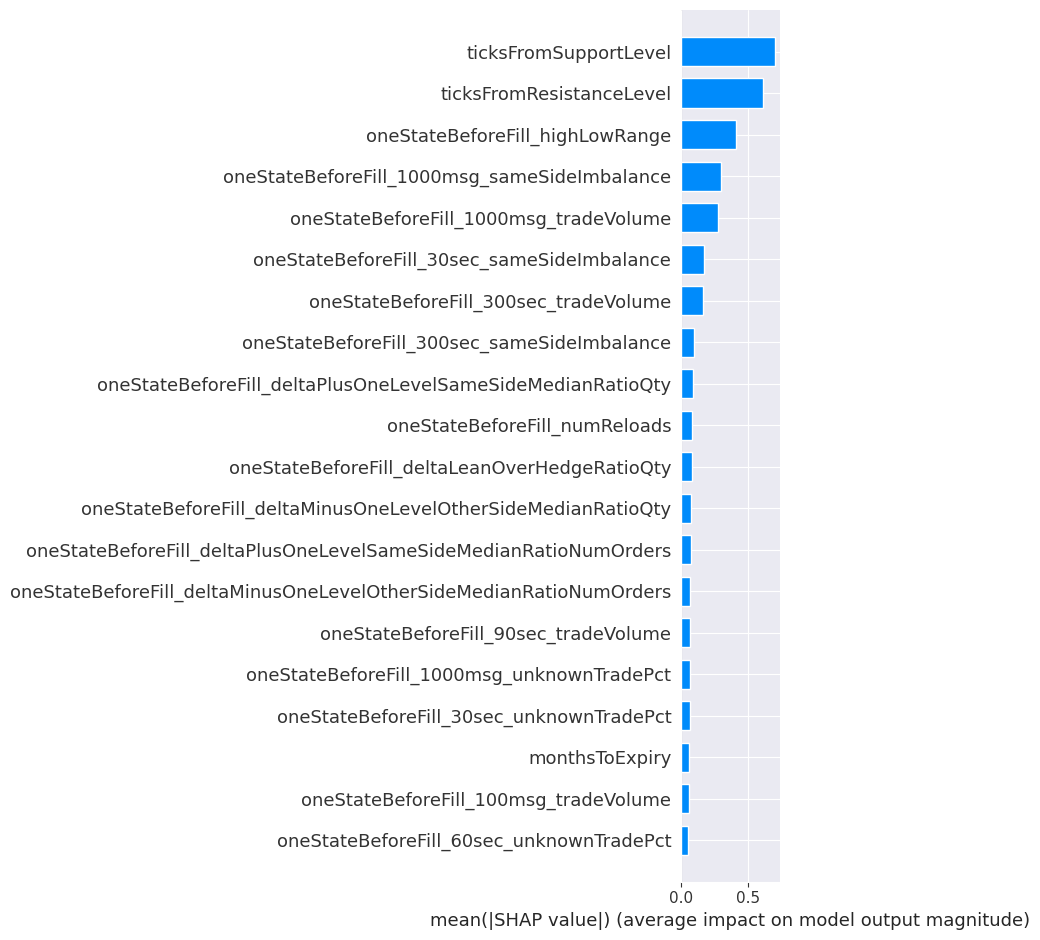

In [9]:
shap.summary_plot(shap_values, feature_names=feature_names, plot_type="bar")
# ax = plt.gca()
# ax.tick_params(axis='both', which='major', labelsize=
               # 12)  # Adjust font size here
# plt.savefig("summaryplot.png")

In [10]:
# data=pd.concat([x_test,x_train],axis=0)

In [11]:
shap.initjs()

In [12]:
Xsample = x_test.sample(n=1000)

In [13]:
# explainer=shap.TreeExplainer(model,Xsample,"probability","interventional",feature_names)
explainer=shap.TreeExplainer(model,Xsample,"raw",feature_names=feature_names)

In [14]:
# explainer = shap.TreeExplainer(model,feature_perturbation="",model_output="log_loss")
shap_values=explainer.shap_values(X=Xsample)

In [15]:
shap_values

array([[ 0.02952803,  0.00452855, -0.00373742, ..., -0.011242  ,
        -0.80649223,  0.09522408],
       [ 0.01050603,  0.03783202, -0.0035869 , ..., -0.01197978,
         0.3021654 , -0.43727051],
       [ 0.01568182, -0.02632595, -0.00504093, ..., -0.01544961,
        -0.17545838, -1.45188029],
       ...,
       [ 0.01785373, -0.03569146, -0.0040111 , ..., -0.00769019,
        -0.16134028,  0.04493522],
       [ 0.02878465,  0.04499762,  0.03490218, ..., -0.0136253 ,
        -1.24368502, -0.31729907],
       [-0.08471734,  0.11456676, -0.00497855, ..., -0.00958983,
         0.45547227, -1.04985208]])

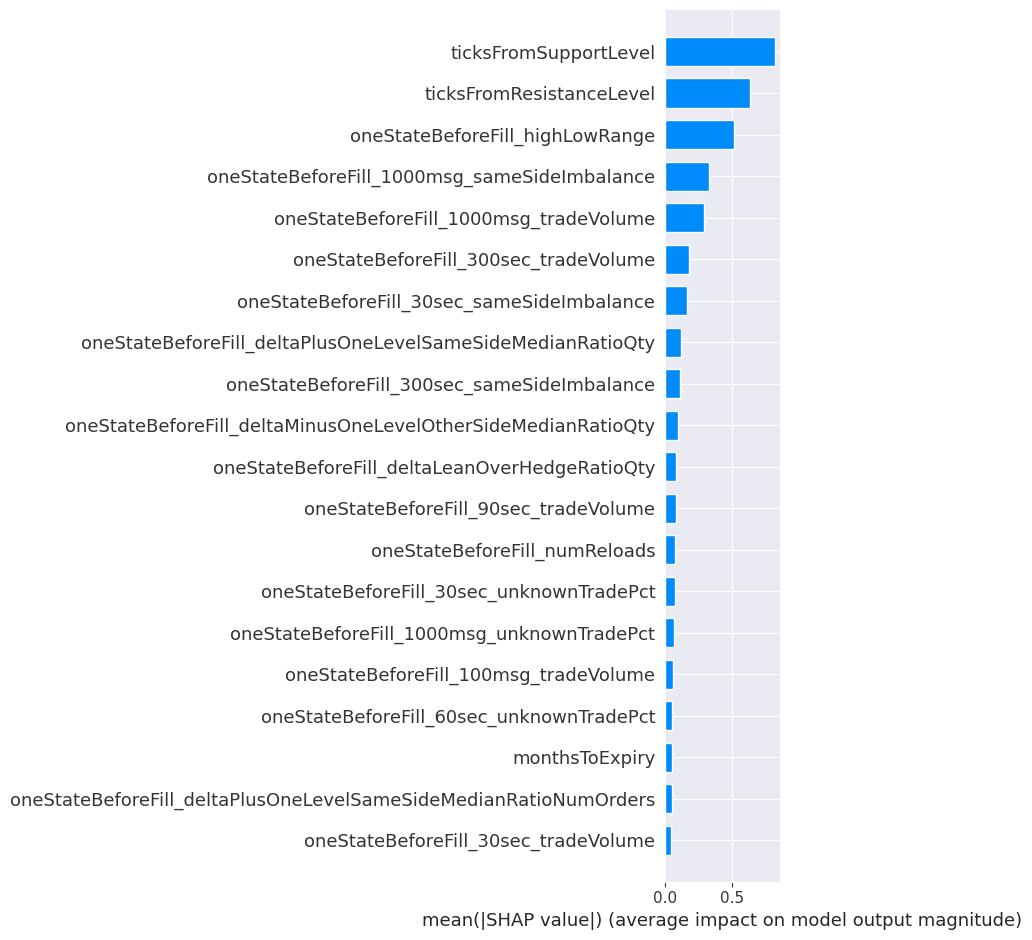

In [16]:
shap.summary_plot(shap_values,Xsample,feature_names,plot_type="bar")

In [17]:
explanation=shap.Explanation(shap_values,feature_names=feature_names)

In [18]:
explanation.values

array([[ 0.02952803,  0.00452855, -0.00373742, ..., -0.011242  ,
        -0.80649223,  0.09522408],
       [ 0.01050603,  0.03783202, -0.0035869 , ..., -0.01197978,
         0.3021654 , -0.43727051],
       [ 0.01568182, -0.02632595, -0.00504093, ..., -0.01544961,
        -0.17545838, -1.45188029],
       ...,
       [ 0.01785373, -0.03569146, -0.0040111 , ..., -0.00769019,
        -0.16134028,  0.04493522],
       [ 0.02878465,  0.04499762,  0.03490218, ..., -0.0136253 ,
        -1.24368502, -0.31729907],
       [-0.08471734,  0.11456676, -0.00497855, ..., -0.00958983,
         0.45547227, -1.04985208]])

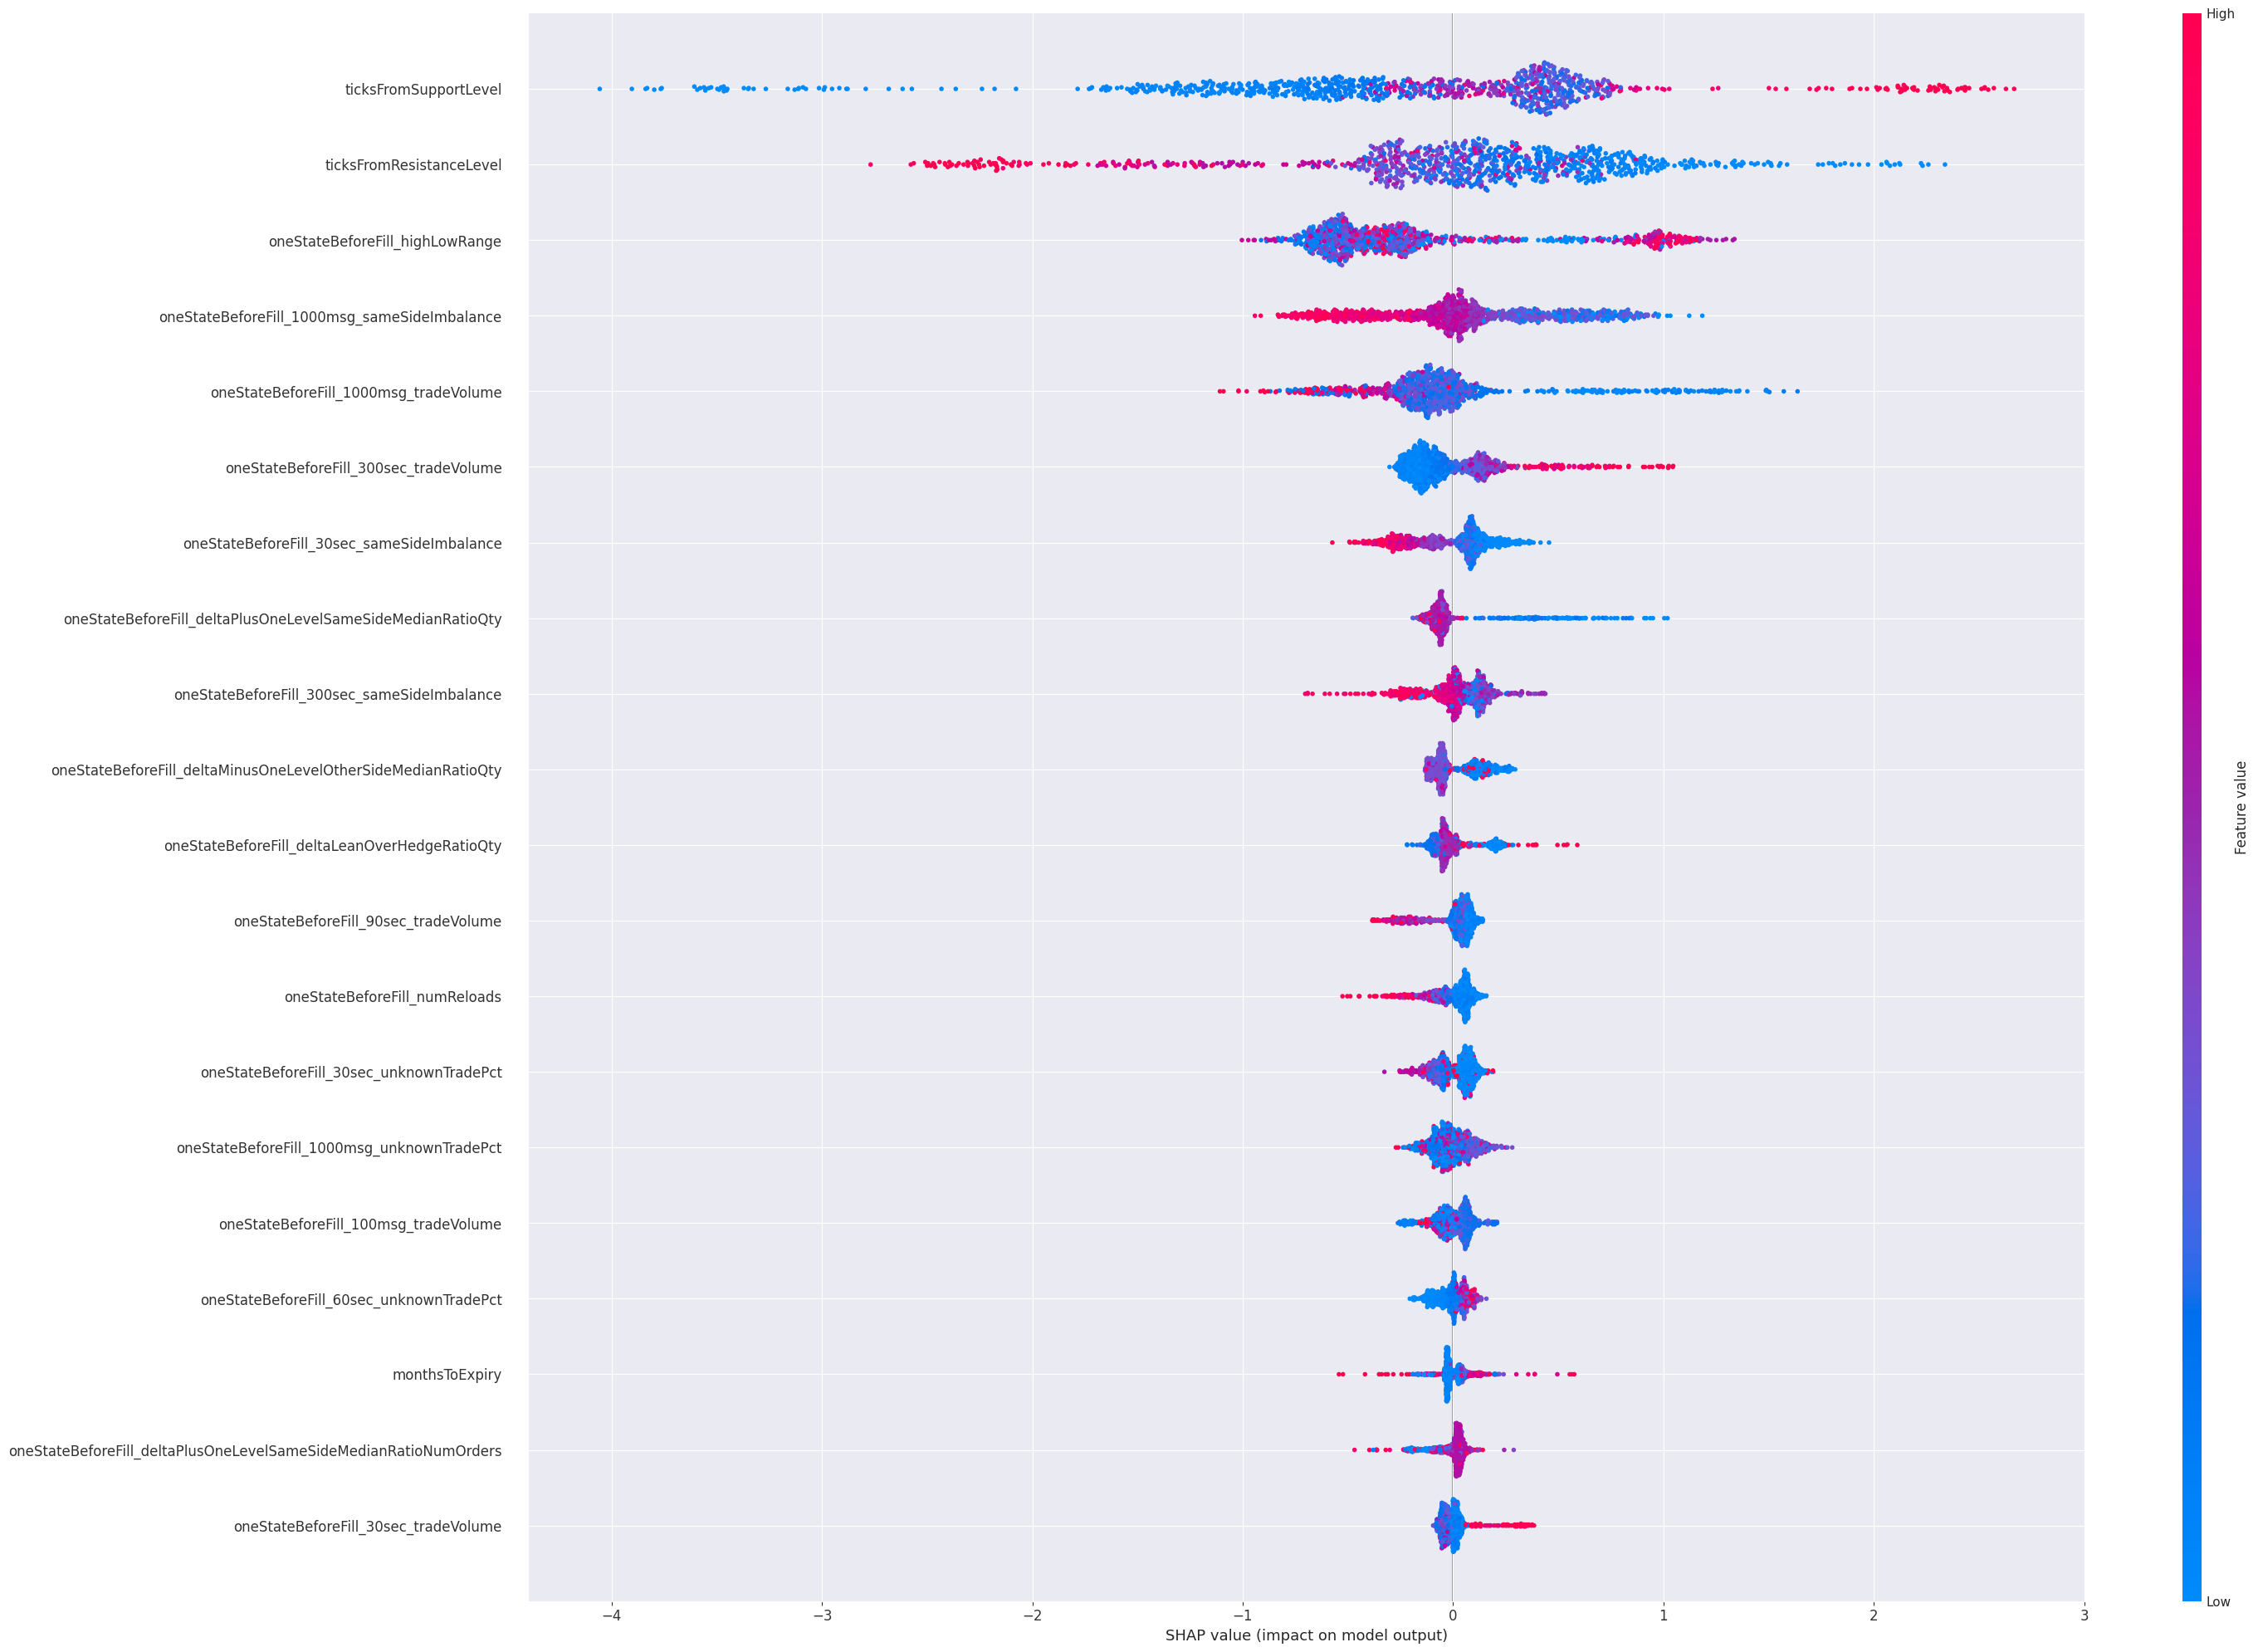

In [19]:
shap.summary_plot(shap_values,Xsample,show=False,plot_size=(30,20))

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=
               12)  # Adjust font size here
# plt.figure(figsize=(18, 20))  # You can adjust these values
plt.tight_layout()
plt.show()

# new 

In [20]:
X=pd.concat([x_train,x_test],axis=0)

In [21]:
y=pd.concat([y_train,y_test],axis=0)

In [22]:
model.fit(X,y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='error@0.7',
              feature_types=None, gamma=0.19, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [23]:
# model.fit(X[400000:410000],y[400000:410000])

In [24]:
explainer=shap.TreeExplainer(model)

In [25]:
shap_values=explainer(X)

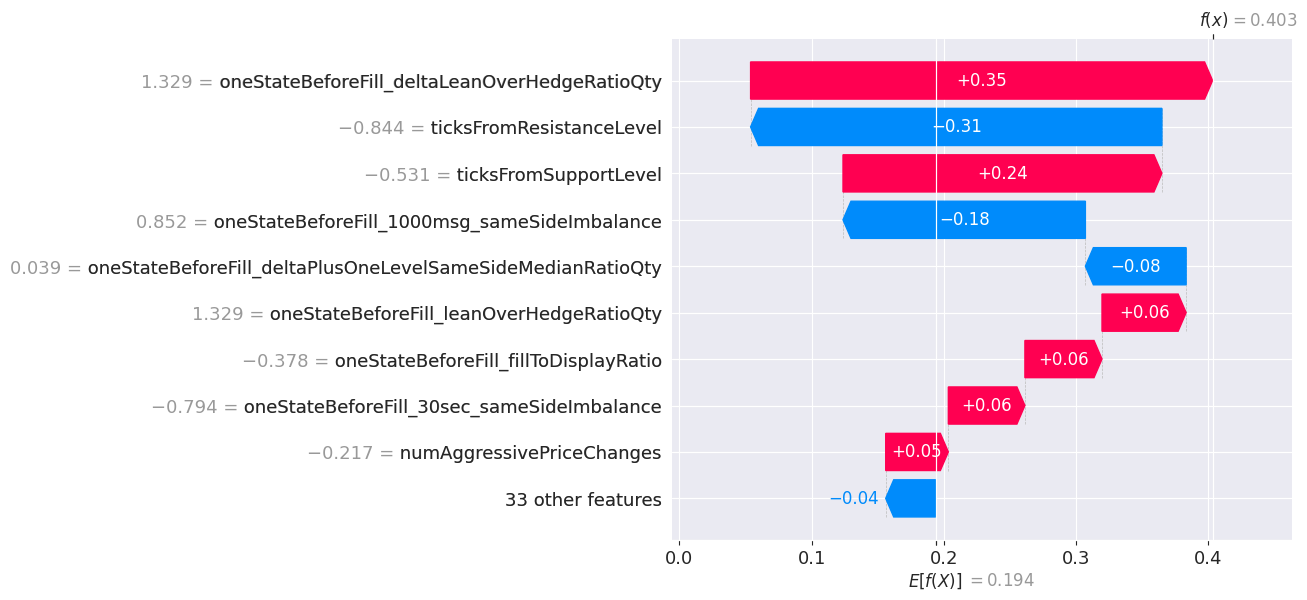

In [26]:
shap.plots.waterfall(shap_values[0])

In [27]:
shap.plots.initjs()

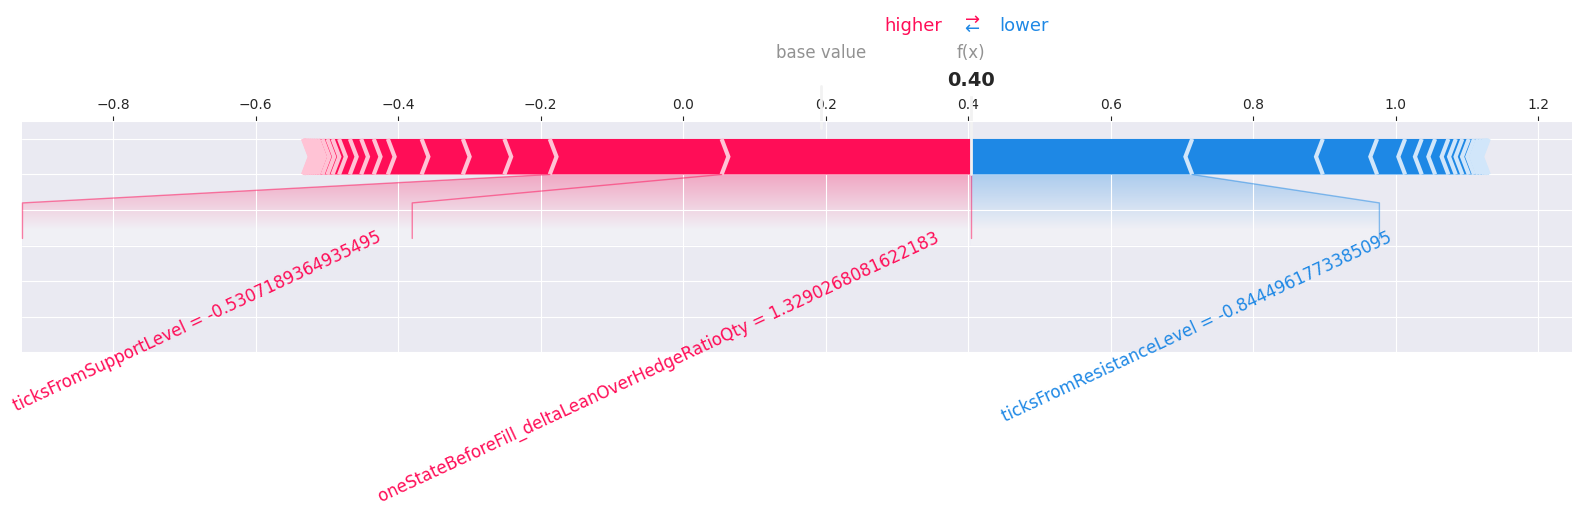

In [28]:
shap.plots.force(shap_values[0],matplotlib=True,contribution_threshold=0.1,text_rotation=25,plot_cmap="BuGn")

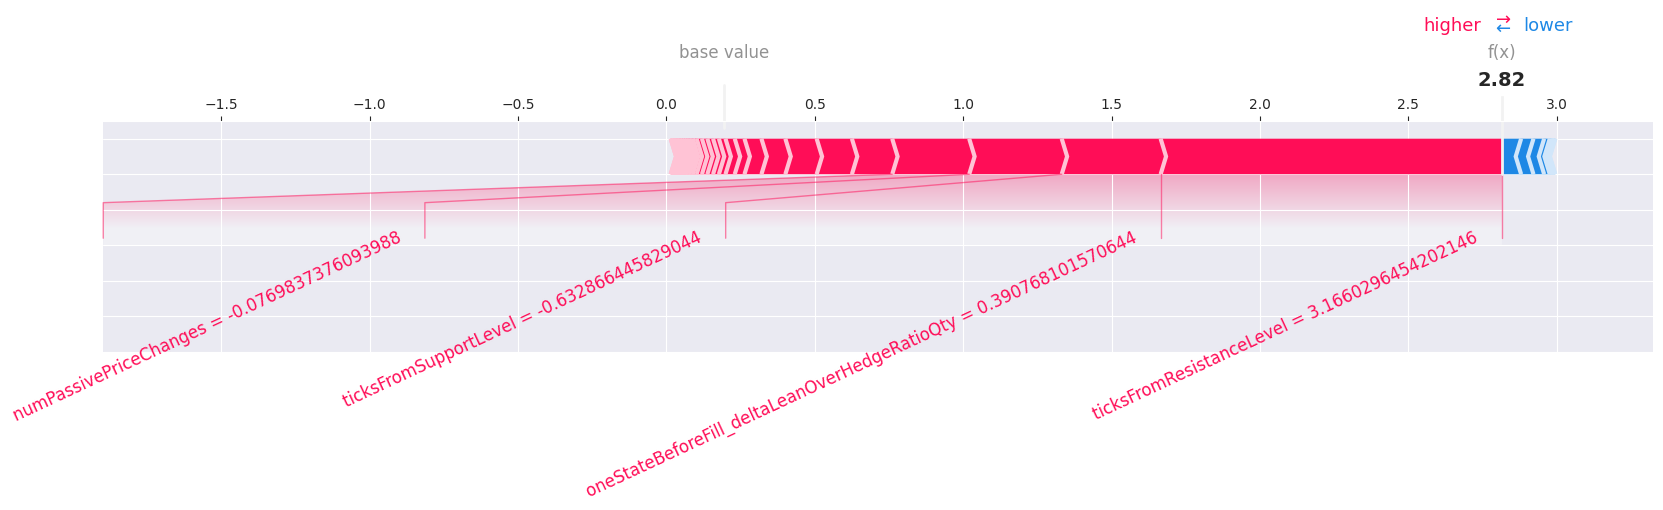

In [29]:
shap.plots.force(shap_values[5],matplotlib=True,contribution_threshold=0.1,text_rotation=25,plot_cmap="BuGn")

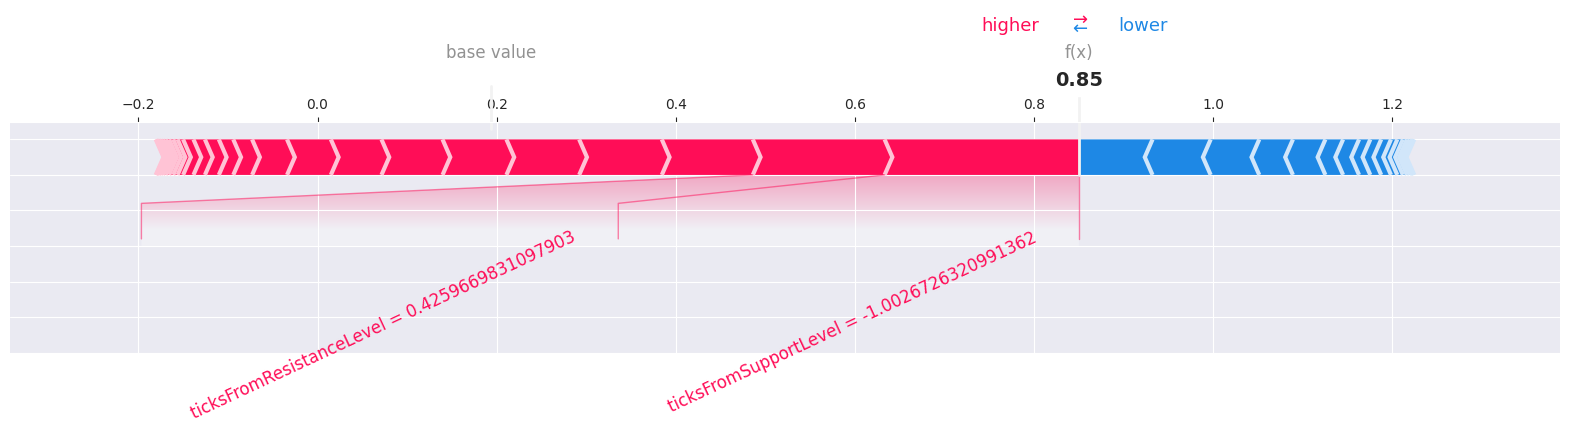

In [30]:
# visualize the first prediction's explanation with a force plotBu
shap.plots.force(shap_values[10000],matplotlib=True,contribution_threshold=0.1,text_rotation=25,plot_cmap="BuGn")

In [31]:
model.fit(X[400000:410000],y[400000:410000])
explainer=shap.TreeExplainer(model,data=X[400000:410000],model_output="probability",feature_perturbation="interventional",feature_names=feature_names)


In [32]:
shap_values=explainer(X[400000:410000])

100%|===================| 9976/10000 [01:51<00:00]        

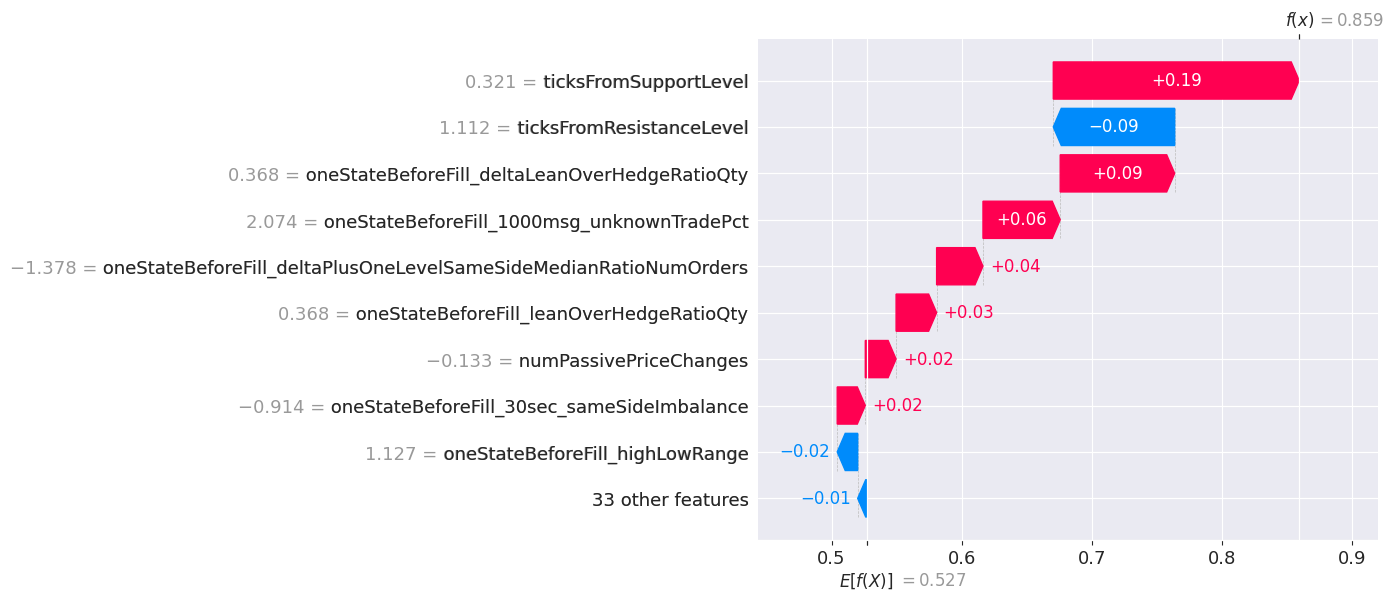

In [33]:
shap.plots.waterfall(shap_values[0])

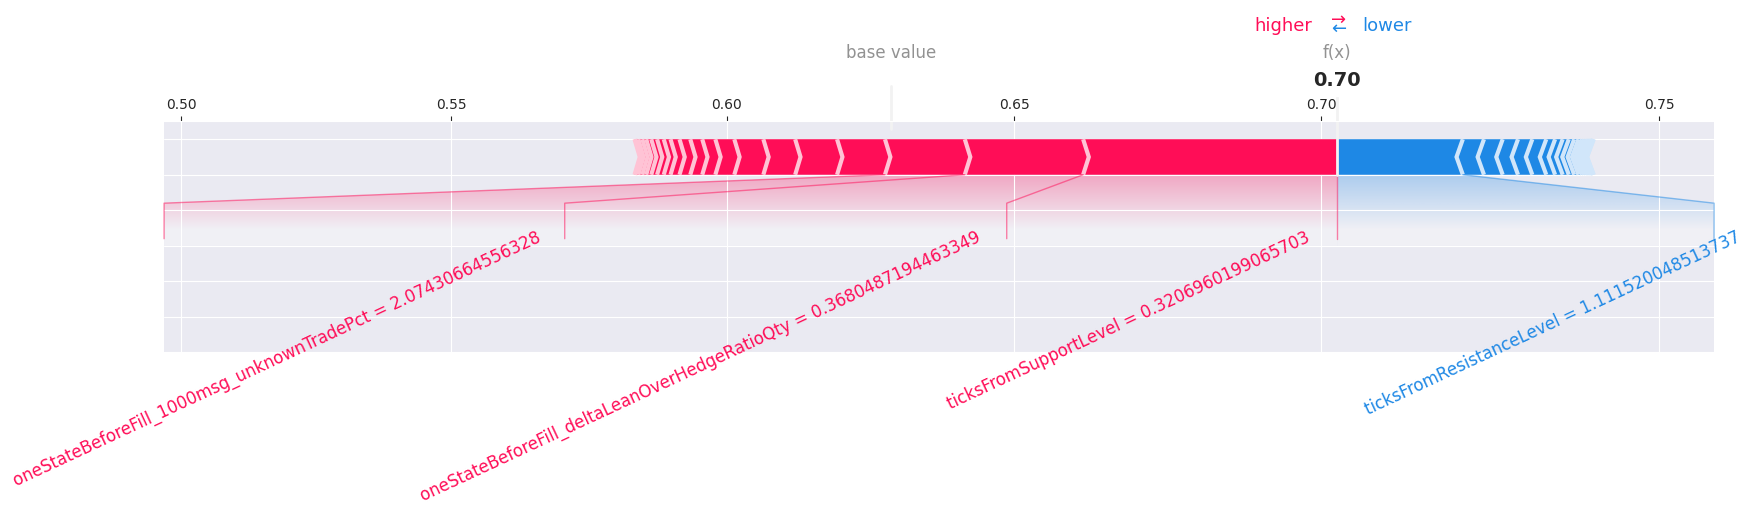

In [39]:
# visualize the first prediction's explanation with a force plotBu
shap.plots.force(shap_values[0],matplotlib=True,contribution_threshold=0.1,text_rotation=25,plot_cmap="BuGn",link="logit")